## Import packages

In [1]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene, bartlett
from scipy.stats import mannwhitneyu
import pandas as pd
from scipy.stats import ttest_ind
import Levenshtein
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

In [2]:
def ConhenD(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)  # 使用Bessel校正
    std2 = np.std(group2, ddof=1)

    # 计算Cohen's d
    pooled_std = np.sqrt(((len(group1)-1) * std1**2 + (len(group2)-1) * std2**2) / (len(group1) + len(group2) - 2))
    cohen_d = (mean1 - mean2) / pooled_std

    print("Cohen's d:", cohen_d)


def diff_analysis(vector1, vector2):
    # 进行Levene方差比较检验
    statistic, p_value_var = levene(vector1, vector2)

    print("Levene's test statistic for variance comparison:", statistic)
    print("P-value for variance comparison:", p_value_var)
    equal_var = None
    # 根据方差比较结果选择t检验方法
    if p_value_var < 0.05:
        ttest_method = 'Mann-Whitney U'
        equal_var = False  # 使用 Mann-Whitney U
    else:
        ttest_method = 'Student'
        equal_var = True   # 使用Student's t-test
    statistic = None
    p_value = None
    # 进行t检验
    if equal_var:
        statistic, p_value = ttest_ind(vector1, vector2, equal_var=equal_var)
    else:
        statistic, p_value = mannwhitneyu(vector1, vector2)
    print(f"The statistical value of t test is STA: {statistic} and p_value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis using {ttest_method}'s t-test: There is a significant difference between the two vectors.")
    else:
        print(f"Fail to reject the null hypothesis using {ttest_method}'s t-test: There is no significant difference between the two vectors.")

def draw_box(vector1, vector2, name = "default"):
    # 使用Seaborn绘制核密度估计图
    # 将两组数据放在一个列表中
    data = [vector1, vector2]
    # 绘制并列箱型图
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Control group', 'Experiment group'])
    plt.ylabel('Value')
    plt.title(name)
    plt.show()

def draw_kde_BLOCK(array1, array2, array3, array4, name = "default"):
    # 创建一个包含两个子图的大图
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 绘制左边的KDE图
    sns.kdeplot(array1, label='Control group', ax=axes[0], fill=True)
    sns.kdeplot(array2, label='Experiment group', ax=axes[0], fill=True)
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('TYPE 0: IMPORTANT ITEM')
    axes[0].legend()
    axes[0].set_xlim(-1, 3)
    # 绘制右边的KDE图
    sns.kdeplot(array3, label='Control group', ax=axes[1], fill=True)
    sns.kdeplot(array4, label='Experiment group', ax=axes[1], fill=True)
    axes[1].set_xlabel('Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('TYPE 1: SMALL ITEM')
    axes[1].legend()
    axes[1].set_xlim(-1, 3)
    # 调整子图之间的间距
    plt.tight_layout()
    
    
    # 显示图形
    plt.show()
    
def array_variable_diff(LIKE, REMEMBER, LOCATION, ORIENTATION, name = "default"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_like = perform_shapiro_test(LIKE)
    p_remember = perform_shapiro_test(REMEMBER)
    p_location = perform_shapiro_test(LOCATION)
    p_orientation = perform_shapiro_test(ORIENTATION)

    print("正态性检验结果:")
    print("喜好程度:", p_like)
    print("辅助记忆区域:", p_remember)
    print("辅助定位:", p_location)
    print("辅助认知朝向:", p_orientation)
    # 执行方差齐性检验
    p_levene = perform_levene_test(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([LIKE, REMEMBER, LOCATION, ORIENTATION])
    labels = ['PREFERENCE'] * len(LIKE) + ['MEMORY'] * len(REMEMBER) + ['LOCATING'] * len(LOCATION) + ['ORIENTATION'] * len(ORIENTATION)

    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    result.plot_simultaneous()
    plt.title(name)
    plt.xlabel("Score")
    plt.show()

    # 计算平均分数
    average_like = sum(LIKE) / len(LIKE)
    average_remember = sum(REMEMBER) / len(REMEMBER)
    average_location = sum(LOCATION) / len(LOCATION)
    average_orientation = sum(ORIENTATION) / len(ORIENTATION)

    # 构建一个字典，方便后续处理
    average_scores = {
        "喜好程度": average_like,
        "辅助记忆区域": average_remember,
        "辅助定位": average_location,
        "辅助认知朝向": average_orientation
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")

    
def n_array_variable_diff(COLOR, LABEL, LANDMARK, name = "default"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_color = perform_shapiro_test(COLOR)
    p_label = perform_shapiro_test(LABEL)
    p_landmark = perform_shapiro_test(LANDMARK)

    print("正态性检验结果:")
    print("COLOR:", p_color)
    print("LABEL:", p_label)
    print("LANDMARK:", p_landmark)
    # 执行方差齐性检验
    p_levene = perform_levene_test(COLOR, LABEL, LANDMARK)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(COLOR, LABEL, LANDMARK)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([COLOR, LABEL, LANDMARK])
    labels = ['COLOR'] * len(COLOR) + ['LABEL'] * len(LABEL) + ['LANDMARK'] * len(LANDMARK)

    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    result.plot_simultaneous()
    plt.title(name)
    plt.xlabel("Score")
    plt.show()

    # 计算平均分数
    average_color = sum(COLOR) / len(COLOR)
    average_label = sum(LABEL) / len(LABEL)
    average_landmark = sum(LANDMARK) / len(LANDMARK)

    # 构建一个字典，方便后续处理
    average_scores = {
        "COLOR": average_color,
        "LABEL": average_label,
        "LANDMARK": average_landmark
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")    

def corr_analysis(scene_familiar, average_sod, familiar_mr, score):
    corr1, p_value1 = spearmanr(scene_familiar, score)
    corr2, p_value2 = spearmanr(average_sod, score)
    corr3, p_value3 = spearmanr(familiar_mr, score)

    # 打印相关性系数和p值
    print("Spearman Correlation and p-value for scene familiarity:", corr1, p_value1)
    print("Spearman Correlation and p-value for sod:", corr2, p_value2)
    print("Spearman Correlation and p-value for mr familiarity:", corr3, p_value3)

def model_analysis(scene_familiar, average_sod, familiar_mr, score):
    data = pd.DataFrame({
        'Scene familiarity': scene_familiar,
        'SOD score': average_sod,
        'MR familiarity': familiar_mr,
        'Score': score
    })

    # 绘制散点矩阵（Pair Plot）
    sns.pairplot(data)
    plt.show()

    # 绘制相关系数热力图
    correlation_matrix = data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # 将自变量合并成一个特征矩阵
    X = np.column_stack((scene_familiar, average_sod, familiar_mr))

    # 划分数据集为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, score, test_size=0.2, random_state=42)
    # X_train, X_test, y_train, y_test = X, X, score, score
    # 线性回归
    linear_model = LinearRegression(fit_intercept = True)
    linear_model.fit(X_train, y_train)
    linear_y_pred = linear_model.predict(X_test)
    linear_mse = mean_squared_error(y_test, linear_y_pred)
    linear_r2 = r2_score(y_test, linear_y_pred)

    # 多项式回归
    poly = PolynomialFeatures(degree=2)  # 二次多项式
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, score, test_size=0.2, random_state=42)
    # X_train_poly, X_test_poly, y_train, y_test = X_poly, X_poly, score, score
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    poly_y_pred = poly_model.predict(X_test_poly)
    poly_mse = mean_squared_error(y_test, poly_y_pred)
    poly_r2 = r2_score(y_test, poly_y_pred)

    # 岭回归
    ridge_model = Ridge(alpha=1.0)  # 可调整alpha参数
    ridge_model.fit(X_train, y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_mse = mean_squared_error(y_test, ridge_y_pred)
    ridge_r2 = r2_score(y_test, ridge_y_pred)

    # Lasso回归
    lasso_model = Lasso(alpha=0.1)  # 可调整alpha参数
    lasso_model.fit(X_train, y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_mse = mean_squared_error(y_test, lasso_y_pred)
    lasso_r2 = r2_score(y_test, lasso_y_pred)

    # 决策树
    tree_model = DecisionTreeRegressor(random_state=42)
    tree_model.fit(X_train, y_train)
    tree_y_pred = tree_model.predict(X_test)
    tree_mse = mean_squared_error(y_test, tree_y_pred)
    tree_r2 = r2_score(y_test, tree_y_pred)


    # 输出结果
    print("Linear Regression:")
    print(f"Mean Squared Error: {linear_mse}")
    print(f"R-squared: {linear_r2}")
    print("\nPolynomial Regression:")
    print(f"Mean Squared Error: {poly_mse}")
    print(f"R-squared: {poly_r2}")
    print("\nRidge Regression:")
    print(f"Mean Squared Error: {ridge_mse}")
    print(f"R-squared: {ridge_r2}")
    print("\nLasso Regression:")
    print(f"Mean Squared Error: {lasso_mse}")
    print(f"R-squared: {lasso_r2}")
    print("\nDecision Tree Regression:")
    print(f"Mean Squared Error: {tree_mse}")
    print(f"R-squared: {tree_r2}")

## BACKGROUND ANALYSIS

### Import data

In [3]:
CO_NUMS = list(range(1, 18))
EX_NUMS = list(range(1, 18))
co_json_datas = []
ex_json_datas = []
for name in CO_NUMS:
    with open('./CO/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    co_json_datas.append(data)
for name in EX_NUMS:
    with open('./EX/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    ex_json_datas.append(data)

### SOD Analysis

In [4]:
sod_questions_number = [0, 1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16]
sod_questions_op = ['-', '+', '-', '-', '+', '+', '+', '+', '+', '-', '+', '+', '+']

In [5]:
sod_length = len(sod_questions_number)

def sod_data(arr):
    sod_matrix = []
    for item in arr:
        tmp_arr = []
        for idx in range(sod_length):
            score = item["direction"][sod_questions_number[idx]]
            if sod_questions_op[idx] == '-':
                score = 7 - score
            tmp_arr.append(score)
        sod_matrix.append(tmp_arr)
    return sod_matrix
sod_co = np.array(sod_data(co_json_datas))
sod_ex = np.array(sod_data(ex_json_datas))

**Difference analysis**

In [6]:
sod_question_labels = list(map(lambda x: 'Q' + str(x + 1), sod_questions_number))
average_sod_co = np.mean(sod_co, axis=1)
average_sod_ex = np.mean(sod_ex, axis=1)

In [7]:
# 创建两个向量，代表两个样本
vector1 = average_sod_co
vector2 = average_sod_ex
print(np.mean(vector1), np.mean(vector2))
diff_analysis(vector1, vector2)

4.3031674208144794 4.484162895927603
Levene's test statistic for variance comparison: 0.15657875422028675
P-value for variance comparison: 0.6949520257667146
The statistical value of t test is STA: -0.5384245777988347 and p_value: 0.5940098241873633
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Familiarity to AR & VR

In [8]:
mr_fam_questions_number = [17, 18]
co_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in co_json_datas]))
ex_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in ex_json_datas]))

# 创建两个向量，代表两个样本
vector1 = co_familiar_mr
vector2 = ex_familiar_mr
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

1.7941176470588236 2.764705882352941
Levene's test statistic for variance comparison: 2.232067510548524
P-value for variance comparison: 0.144969009454543
The statistical value of t test is STA: -1.7614096918559585 and p_value: 0.0877224678854483
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Scene Familiarity

In [9]:
co_scene_familiar = []
ex_scene_familiar = []
for item in co_json_datas:
    co_scene_familiar.append(item['post'][0])
for item in ex_json_datas:
    ex_scene_familiar.append(item['post'][0])
vector1 = co_scene_familiar
vector2 = ex_scene_familiar
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

2.5294117647058822 3.5294117647058822
Levene's test statistic for variance comparison: 2.024999999999999
P-value for variance comparison: 0.16440561108082208
The statistical value of t test is STA: -1.5026019100214134 and p_value: 0.14274698294970953
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


## QUANT ANALYSIS

In [10]:
# 读取 CSV 文件
df_EX = pd.read_csv("./EX/spatial.csv", skip_blank_lines=False)
df_CO = pd.read_csv("./CO/spatial.csv", skip_blank_lines=False)

# 找到空行的索引
blank_line_indices_ex = df_EX.index[df_EX.isnull().all(1)]
blank_line_indices_co = df_CO.index[df_CO.isnull().all(1)]

# 初始化三个空的 DataFrame
dataframes_ex = []
start_idx_ex = 0

dataframes_co = []
start_idx_co = 0


# 根据空行的索引将数据分割成三个 DataFrame
for idx in blank_line_indices_ex:
    dataframes_ex.append(df_EX.iloc[start_idx_ex:idx])
    start_idx_ex = idx + 1

for idx in blank_line_indices_co:
    dataframes_co.append(df_CO.iloc[start_idx_co:idx])
    start_idx_co = idx + 1
    
# 处理最后一个部分（如果有剩余的数据）
if start_idx_ex < len(df_EX):
    dataframes_ex.append(df_EX.iloc[start_idx_ex:])
if start_idx_co < len(df_CO):
    dataframes_co.append(df_CO.iloc[start_idx_co:])
print(len(dataframes_ex))
print(len(dataframes_co))

3
3


In [11]:
print("STATS for experiment units: ")
for idx, df in enumerate(dataframes_ex):
    # 根据 "type" 列进行分组
    df["TYPE"].astype(int)
    df["TYPE"].astype(str)

    grouped = df.groupby("TYPE")
    
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 18)]

    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print("BLOCK ", idx + 1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 18)]
merged_df_ex = pd.concat(dataframes_ex, ignore_index=True)
grouped_ex = merged_df_ex.groupby("TYPE")
avg_frame_ex = grouped_ex[columns_to_average].mean()
avg_ex = avg_frame_ex.mean(axis=1)
print("Overall avg: ")
print(avg_ex)

STATS for experiment units: 
BLOCK  1
TYPE
0.0    0.978328
1.0    0.348039
dtype: float64
BLOCK  2
TYPE
0.0    0.571429
1.0    0.831933
dtype: float64
BLOCK  3
TYPE
0.0    1.023529
1.0    0.750000
dtype: float64
Overall avg: 
TYPE
0.0    0.893738
1.0    0.641869
dtype: float64


In [12]:
print("STATS for control units: ")
for idx, df in enumerate(dataframes_co):
    # 根据 "type" 列进行分组
    df["TYPE"] = df["TYPE"].astype(int)
    df["TYPE"] = df["TYPE"].astype(str)
    grouped = df.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 18)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 18)]
merged_df_co = pd.concat(dataframes_co, ignore_index=True)
grouped_co = merged_df_co.groupby("TYPE")
avg_frame_co = grouped_co[columns_to_average].mean()
avg_co = avg_frame_co.mean(axis=1)
print("Overall avg: ")
print(avg_co)

STATS for control units: 
BLOCK  1
TYPE
0    0.111455
1    0.044118
dtype: float64
BLOCK  2
TYPE
0    0.184874
1    0.306723
dtype: float64
BLOCK  3
TYPE
0    0.305882
1    0.227941
dtype: float64
Overall avg: 
TYPE
0    0.159393
1    0.195502
dtype: float64


<ipython-input-12-77170f8e5eca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(int)
<ipython-input-12-77170f8e5eca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(str)
<ipython-input-12-77170f8e5eca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

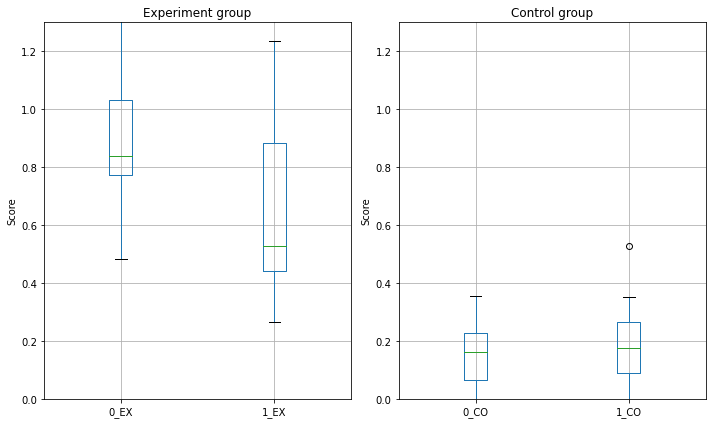

In [13]:
avg_frame_ex.index = avg_frame_ex.index.map(lambda x: str(int(x)) + "_EX")
avg_frame_co.index = avg_frame_co.index.map(lambda x: str(int(x)) + "_CO")
avg_frame_ex = avg_frame_ex.T
avg_frame_co = avg_frame_co.T

# 绘制箱线图
plt.figure(figsize=(10, 6))

# 绘制 frame1 的箱线图
plt.subplot(1, 2, 1)
avg_frame_ex.boxplot()
plt.ylim(0, 1.3)
plt.title("Experiment group")
plt.ylabel("Score")
# 绘制 frame2 的箱线图
plt.subplot(1, 2, 2)
avg_frame_co.boxplot()
plt.ylim(0, 1.3)
plt.title("Control group")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [14]:
diff_analysis(avg_frame_ex["0_EX"].tolist(), avg_frame_ex["1_EX"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_co["1_CO"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_ex["0_EX"].tolist())
diff_analysis(avg_frame_co["1_CO"].tolist(), avg_frame_ex["1_EX"].tolist())

Levene's test statistic for variance comparison: 0.9037546149513808
P-value for variance comparison: 0.34890237977566785
The statistical value of t test is STA: 2.7262683761475386 and p_value: 0.010303880548238532
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 0.047491567695653825
P-value for variance comparison: 0.8288708151937654
The statistical value of t test is STA: -0.8532206191560341 and p_value: 0.39987864087087044
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Levene's test statistic for variance comparison: 3.9413271245634487
P-value for variance comparison: 0.05574007811727887
The statistical value of t test is STA: -11.348656421789011 and p_value: 9.401730067226628e-13
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test st

BLOCK  1


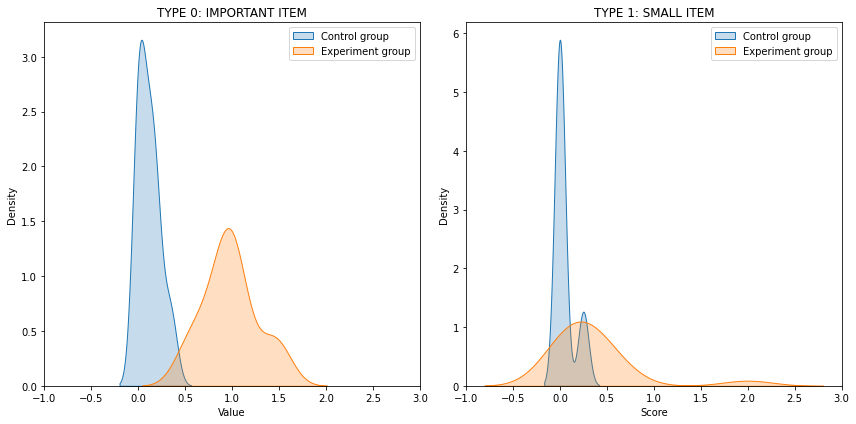

BLOCK  2


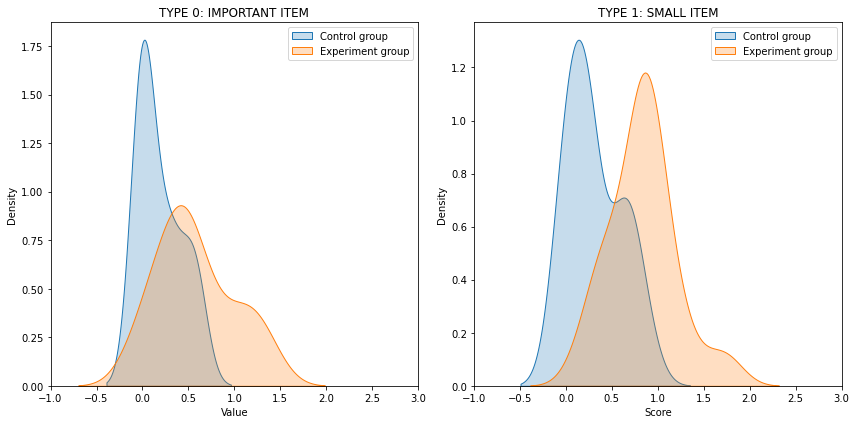

BLOCK  3


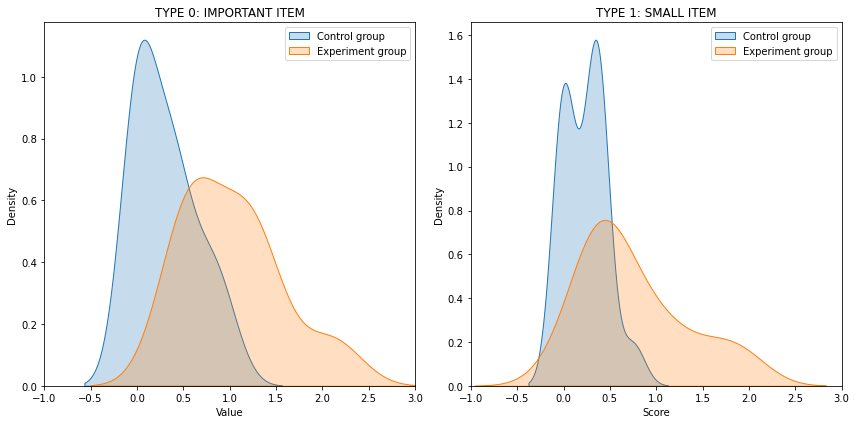

In [15]:
for idx, (df_c, df_e) in enumerate(zip(dataframes_co, dataframes_ex)):
    grouped_c = df_c.groupby("TYPE")
    grouped_e = df_e.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 18)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages_e = grouped_e[columns_to_average].mean()
    averages_c = grouped_c[columns_to_average].mean()
    row_list_e_1 = averages_e.iloc[0].tolist()
    row_list_e_2 = averages_e.iloc[1].tolist()
    row_list_c_1 = averages_c.iloc[0].tolist()
    row_list_c_2 = averages_c.iloc[1].tolist()
    draw_kde_BLOCK(row_list_c_1, row_list_e_1, row_list_c_2, row_list_e_2)

## Edit distance

In [16]:
co_edit_json = None
ex_edit_json = None
with open('./CO/editDis.json', 'r') as json_file:
    co_edit_json = json.load(json_file)
with open('./EX/editDis.json', 'r') as json_file:
    ex_edit_json = json.load(json_file)
standard_structure = co_edit_json["standard"]
del co_edit_json["standard"]
del ex_edit_json["standard"]
keys = ["1-1", "1-2", "2-1", "2-2", "3-1", "3-2"]
co_edit_score = []
ex_edit_score = []

for item in co_edit_json:
    tmp_arr = []
    item = co_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    co_edit_score.append(n_tmp_arr)
for item in ex_edit_json:
    tmp_arr = []
    item = ex_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    ex_edit_score.append(n_tmp_arr)
print(np.mean(np.array(co_edit_score)), np.mean(np.array(ex_edit_score)))
overall_co_edit_score = [np.mean(item) for item in co_edit_score]
overall_ex_edit_score = [np.mean(item) for item in ex_edit_score]

0.9438524789568434 0.7016864644948134


Levene's test statistic for variance comparison: 7.867343212046488
P-value for variance comparison: 0.008489146982820344
The statistical value of t test is STA: 284.0 and p_value: 1.6843760410602689e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


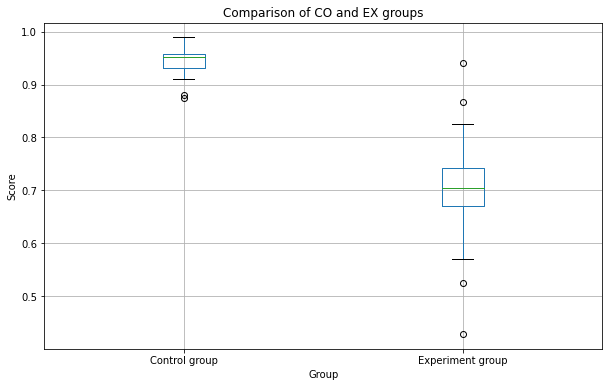

In [17]:
diff_analysis(overall_co_edit_score, overall_ex_edit_score)
df = pd.DataFrame({'Control group': overall_co_edit_score, 'Experiment group': overall_ex_edit_score})

# 使用Seaborn绘制小提琴图
plt.figure(figsize=(10, 6))
df.boxplot()
plt.xlabel('Group')
plt.ylabel('Score')
plt.title('Comparison of CO and EX groups')
plt.show()

BLOCK 1
CO:  0.9321266968325792 , EX:  0.6877828054298643
Levene's test statistic for variance comparison: 6.795294117647068
P-value for variance comparison: 0.013764938091063144
The statistical value of t test is STA: 257.5 and p_value: 7.617595029886147e-05
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


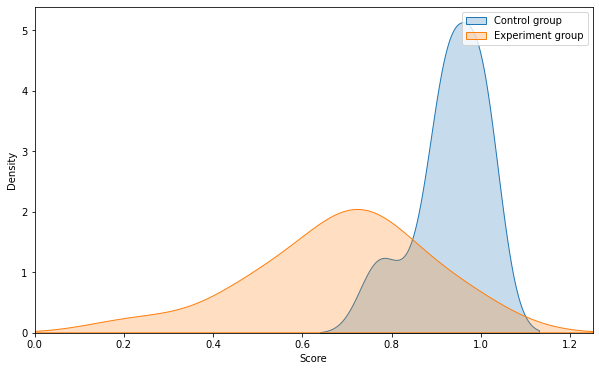



BLOCK 2
CO:  0.9582542694497155 , EX:  0.7001897533206831
Levene's test statistic for variance comparison: 6.585930543187889
P-value for variance comparison: 0.015162544593021186
The statistical value of t test is STA: 279.0 and p_value: 3.395181161407918e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


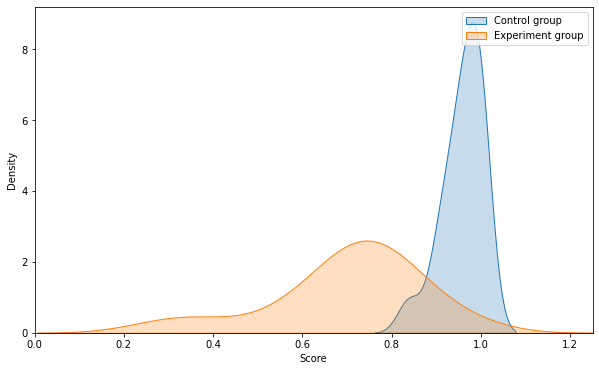



BLOCK 3
CO:  0.9411764705882353 , EX:  0.7170868347338935
Levene's test statistic for variance comparison: 2.8051948051948057
P-value for variance comparison: 0.1037066300819022
The statistical value of t test is STA: 8.78776058209744 and p_value: 4.845835522288871e-10
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


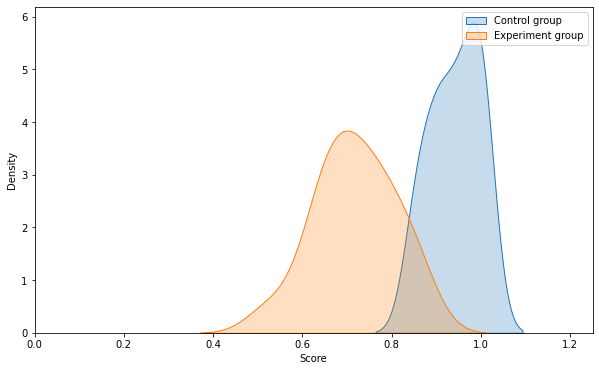

In [18]:
for i in range(3):
    array_c = [item[i] for item in co_edit_score]
    array_e = [item[i] for item in ex_edit_score]
    print("BLOCK " + str(i + 1))
    print("CO: ", np.mean(array_c), ", EX: ", np.mean(array_e))
    diff_analysis(array_c, array_e)
    # 绘制两组数据的核密度估计图
    plt.figure(figsize=(10, 6))
    sns.kdeplot(array_c, label='Control group', fill=True)
    sns.kdeplot(array_e, label='Experiment group', fill=True)
    plt.xlabel('Score')
    plt.ylabel('Density')
    # plt.title('Kernel Density Estimate of Two Data Sets')
    plt.legend()
    plt.xlim(0, 1.25)
    plt.show()
    print("\n")

## POST ANLAYSIS

In [19]:
# Variable
COLORS_IDX = [3, 6, 9, 12]
LABELS_IDX = [4, 7, 10, 13]
LAND_IDX = [5, 8, 11, 14]
OVERALL_EVA_IDX = [16, 17, 18, 21]

In [20]:
ex_colors_eva = []
co_colors_eva = []

ex_labels_eva = []
co_labels_eva = []

ex_land_eva = []
co_land_eva = []

ex_overall_eva = []
co_overall_eva = []

for item in co_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    co_colors_eva.append(color)
    co_labels_eva.append(label)
    co_land_eva.append(land)
    co_overall_eva.append(overall)

for item in ex_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    ex_colors_eva.append(color)
    ex_labels_eva.append(label)
    ex_land_eva.append(land)
    ex_overall_eva.append(overall)

In [21]:
print("COLORS: ")
print(np.mean(ex_colors_eva), np.mean(co_colors_eva))
diff_analysis(ex_colors_eva, co_colors_eva)
ConhenD(ex_colors_eva, co_colors_eva)
print("\n")
print("LABELS: ")
print(np.mean(ex_labels_eva), np.mean(co_labels_eva))
diff_analysis(ex_labels_eva, co_labels_eva)
ConhenD(ex_labels_eva, co_labels_eva)
print("\n")
print("LANDMARKS: ")
print(np.mean(ex_land_eva), np.mean(co_land_eva))
diff_analysis(ex_land_eva, co_land_eva)
ConhenD(ex_land_eva, co_land_eva)
print("\n")
print("COLORS: ")
print(np.mean(ex_overall_eva), np.mean(co_overall_eva))
diff_analysis(ex_overall_eva, co_overall_eva)
ConhenD(ex_overall_eva, co_overall_eva)
print("\n")

COLORS: 
3.838235294117647 3.6323529411764706
Levene's test statistic for variance comparison: 0.5584946823016091
P-value for variance comparison: 0.4603239534534801
The statistical value of t test is STA: 0.3704630729271489 and p_value: 0.7134784903673088
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.1270677857091042


LABELS: 
5.367647058823529 4.955882352941177
Levene's test statistic for variance comparison: 0.26580526072911836
P-value for variance comparison: 0.6097034469113707
The statistical value of t test is STA: 0.899141694936963 and p_value: 0.3752936199623573
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.30840305704865295


LANDMARKS: 
5.794117647058823 5.073529411764706
Levene's test statistic for variance comparison: 1.6640000000000006
P-value for variance comparison: 0.20630882021452723
The statistical

### How do you like each element you saw

正态性检验结果:
COLOR: 0.3843066990375519
LABEL: 0.042762674391269684
LANDMARK: 0.008382744155824184

方差齐性检验结果:
Levene检验p值: 0.36044329725936963

多因素ANOVA结果:
ANOVA p值: 0.24491011152068484

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   0.5294 0.4435 -0.5144 1.5732  False
 COLOR LANDMARK   0.7059 0.2408 -0.3379 1.7497  False
 LABEL LANDMARK   0.1765 0.9121 -0.8673 1.2203  False
-----------------------------------------------------


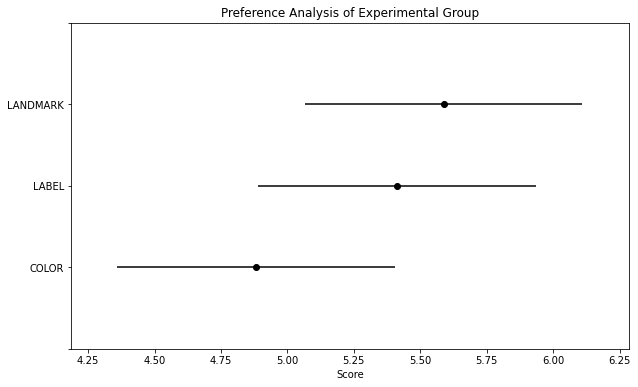

平均分数:
COLOR: 4.88
LABEL: 5.41
LANDMARK: 5.59

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.007831028662621975
LABEL: 0.013239020481705666
LANDMARK: 0.0155388955026865

方差齐性检验结果:
Levene检验p值: 0.06172353500924129

多因素ANOVA结果:
ANOVA p值: 0.18162091130734845

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL      1.0 0.2082 -0.4059 2.4059  False
 COLOR LANDMARK   0.8824 0.2917 -0.5236 2.2883  False
 LABEL LANDMARK  -0.1176 0.9777 -1.5236 1.2883  False
-----------------------------------------------------


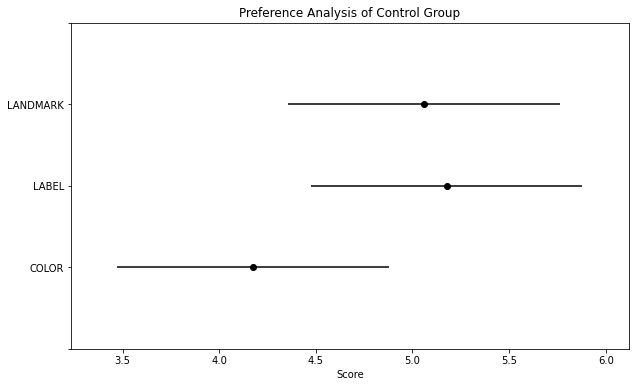

平均分数:
COLOR: 4.18
LABEL: 5.18
LANDMARK: 5.06

用户辅助最大的方面是：LABEL


In [22]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][3])
    CO_LABELS.append(item["post"][4])
    CO_LANDMARKS.append(item["post"][5])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][3])
    EX_LABELS.append(item["post"][4])
    EX_LANDMARKS.append(item["post"][5])
'''    
print("颜色方面：")
print(np.mean(EX_COLORS), np.mean(CO_COLORS))
diff_analysis(EX_COLORS, CO_COLORS)
ConhenD(EX_COLORS, CO_COLORS)
print("\n标签设计方面：")
print(np.mean(EX_LABELS), np.mean(CO_LABELS))
diff_analysis(EX_LABELS, CO_LABELS)
ConhenD(EX_LABELS, CO_LABELS)
print("\n地标设计方面：")
print(np.mean(EX_LANDMARKS), np.mean(CO_LANDMARKS))
diff_analysis(EX_LANDMARKS, CO_LANDMARKS)
ConhenD(EX_LANDMARKS, CO_LANDMARKS)
'''
n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Preference Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Preference Analysis of Control Group")

### How do you think each element helps you remember the area

正态性检验结果:
COLOR: 0.1040324866771698
LABEL: 0.007302337326109409
LANDMARK: 0.0005955854430794716

方差齐性检验结果:
Levene检验p值: 0.29259326957181186

多因素ANOVA结果:
ANOVA p值: 8.557275418472897e-06

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.9412 0.0005  0.7935 3.0889   True
 COLOR LANDMARK   2.4706    0.0  1.3229 3.6183   True
 LABEL LANDMARK   0.5294 0.5093 -0.6183 1.6771  False
-----------------------------------------------------


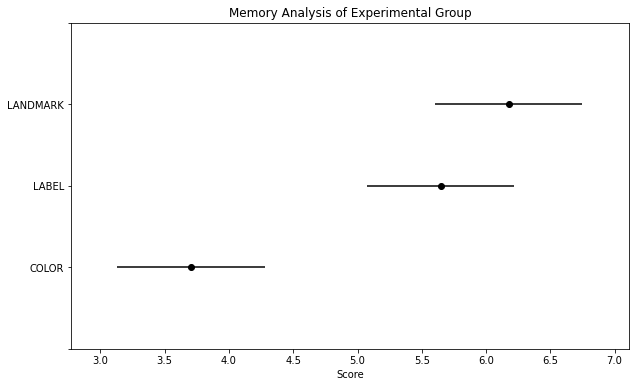

平均分数:
COLOR: 3.71
LABEL: 5.65
LANDMARK: 6.18

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.07201197743415833
LABEL: 0.21940426528453827
LANDMARK: 0.005321977660059929

方差齐性检验结果:
Levene检验p值: 0.059639000861133065

多因素ANOVA结果:
ANOVA p值: 0.01290299846564315

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.4118 0.0409  0.0485 2.7751   True
 COLOR LANDMARK   1.5882 0.0189  0.2249 2.9515   True
 LABEL LANDMARK   0.1765 0.9475 -1.1868 1.5398  False
-----------------------------------------------------


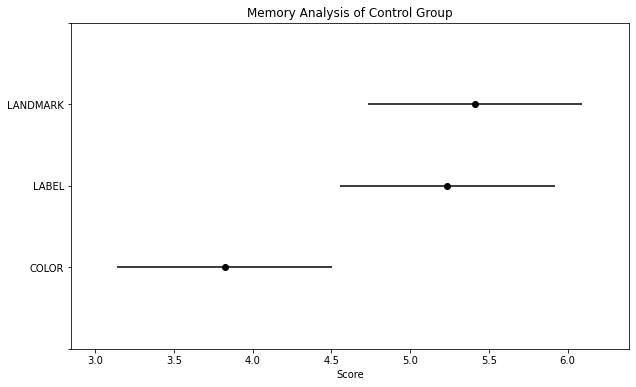

平均分数:
COLOR: 3.82
LABEL: 5.24
LANDMARK: 5.41

用户辅助最大的方面是：LANDMARK


In [23]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][6])
    CO_LABELS.append(item["post"][7])
    CO_LANDMARKS.append(item["post"][8])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][6])
    EX_LABELS.append(item["post"][7])
    EX_LANDMARKS.append(item["post"][8])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Memory Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Memory Analysis of Control Group")

### How do you think each element helps you locate your position

正态性检验结果:
COLOR: 0.07072404772043228
LABEL: 0.0069887349382042885
LANDMARK: 0.0024297882337123156

方差齐性检验结果:
Levene检验p值: 0.1784691523388709

多因素ANOVA结果:
ANOVA p值: 1.1705866940616977e-05

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL      2.0  0.001  0.7402 3.2598   True
 COLOR LANDMARK   2.7059    0.0  1.4461 3.9657   True
 LABEL LANDMARK   0.7059 0.3723 -0.5539 1.9657  False
-----------------------------------------------------


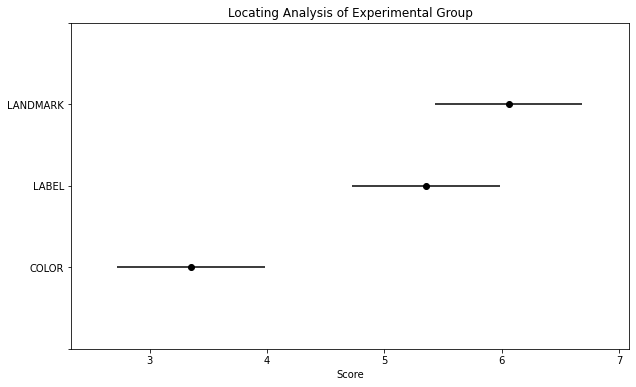

平均分数:
COLOR: 3.35
LABEL: 5.35
LANDMARK: 6.06

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.034413497895002365
LABEL: 0.19358886778354645
LANDMARK: 0.006484044715762138

方差齐性检验结果:
Levene检验p值: 0.8184670084701102

多因素ANOVA结果:
ANOVA p值: 0.0029771017174765354

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.4706 0.0398  0.0569 2.8843   True
 COLOR LANDMARK   2.0588 0.0027  0.6451 3.4725   True
 LABEL LANDMARK   0.5882 0.5765 -0.8255  2.002  False
-----------------------------------------------------


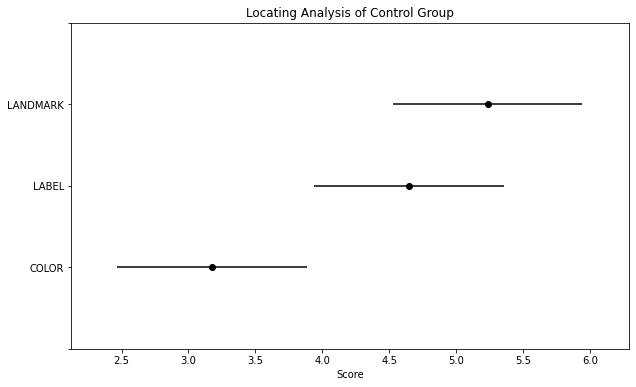

平均分数:
COLOR: 3.18
LABEL: 4.65
LANDMARK: 5.24

用户辅助最大的方面是：LANDMARK


In [24]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][9])
    CO_LABELS.append(item["post"][10])
    CO_LANDMARKS.append(item["post"][11])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][9])
    EX_LABELS.append(item["post"][10])
    EX_LANDMARKS.append(item["post"][11])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Locating Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Locating Analysis of Control Group")

### How do you think each element helps you identify your orientation

正态性检验结果:
COLOR: 0.12218301743268967
LABEL: 0.012811788357794285
LANDMARK: 0.004122786223888397

方差齐性检验结果:
Levene检验p值: 0.8117331668020391

多因素ANOVA结果:
ANOVA p值: 0.007987073365838251

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.6471 0.0346     0.1 3.1941   True
 COLOR LANDMARK   1.9412 0.0106  0.3942 3.4882   True
 LABEL LANDMARK   0.2941 0.8903 -1.2529 1.8411  False
-----------------------------------------------------


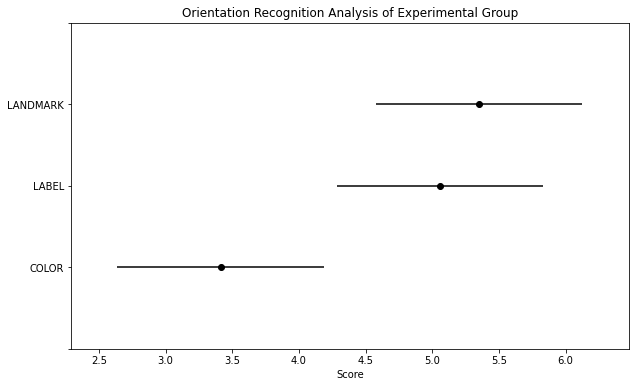

平均分数:
COLOR: 3.41
LABEL: 5.06
LANDMARK: 5.35

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.09299522638320923
LABEL: 0.032714370638132095
LANDMARK: 0.06818811595439911

方差齐性检验结果:
Levene检验p值: 0.957187760813224

多因素ANOVA结果:
ANOVA p值: 0.10802628892445418

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.4118 0.1277 -0.3111 3.1347  False
 COLOR LANDMARK   1.2353 0.2032 -0.4876 2.9582  False
 LABEL LANDMARK  -0.1765 0.9668 -1.8994 1.5464  False
-----------------------------------------------------


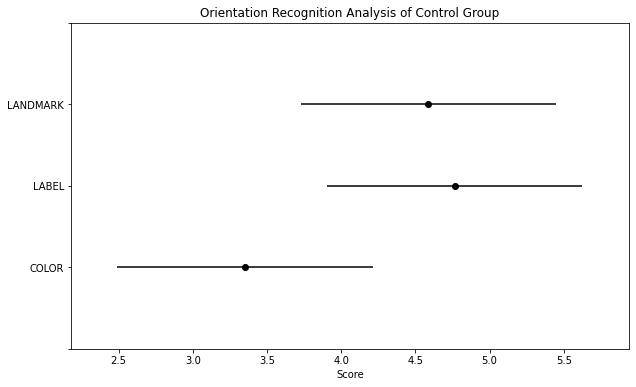

平均分数:
COLOR: 3.35
LABEL: 4.76
LANDMARK: 4.59

用户辅助最大的方面是：LABEL


In [25]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][12])
    CO_LABELS.append(item["post"][13])
    CO_LANDMARKS.append(item["post"][14])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][12])
    EX_LABELS.append(item["post"][13])
    EX_LANDMARKS.append(item["post"][14])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Orientation Recognition Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Orientation Recognition Analysis of Control Group")

### COLORS

正态性检验结果:
喜好程度: 0.3843066990375519
辅助记忆区域: 0.1040324866771698
辅助定位: 0.07072404772043228
辅助认知朝向: 0.12218301743268967

方差齐性检验结果:
Levene检验p值: 0.62133469708486

多因素ANOVA结果:
ANOVA p值: 0.04211202291793907

存在显著差异，可以进行事后分析。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.3529 0.9332 -1.2113 1.9172  False
   LOCATING ORIENTATION   0.0588 0.9996 -1.5054  1.623  False
   LOCATING  PREFERENCE   1.5294 0.0576 -0.0348 3.0936  False
     MEMORY ORIENTATION  -0.2941 0.9597 -1.8583 1.2701  False
     MEMORY  PREFERENCE   1.1765 0.2048 -0.3878 2.7407  False
ORIENTATION  PREFERENCE   1.4706 0.0728 -0.0936 3.0348  False
-------------------------------------------------------------


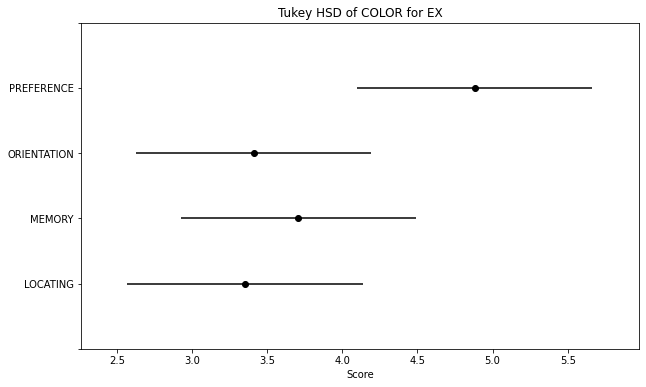

平均分数:
喜好程度: 4.88
辅助记忆区域: 3.71
辅助定位: 3.35
辅助认知朝向: 3.41

用户辅助最大的方面是：喜好程度
正态性检验结果:
喜好程度: 0.007831028662621975
辅助记忆区域: 0.07201197743415833
辅助定位: 0.034413497895002365
辅助认知朝向: 0.09299522638320923

方差齐性检验结果:
Levene检验p值: 0.7497119591444167

多因素ANOVA结果:
ANOVA p值: 0.45694807586772035

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.6471  0.781   -1.16 2.4541  False
   LOCATING ORIENTATION   0.1765 0.9939 -1.6306 1.9835  False
   LOCATING  PREFERENCE      1.0 0.4676  -0.807  2.807  False
     MEMORY ORIENTATION  -0.4706 0.9017 -2.2776 1.3365  False
     MEMORY  PREFERENCE   0.3529 0.9552 -1.4541   2.16  False
ORIENTATION  PREFERENCE   0.8235 0.6277 -0.9835 2.6306  False
-------------------------------------------------------------


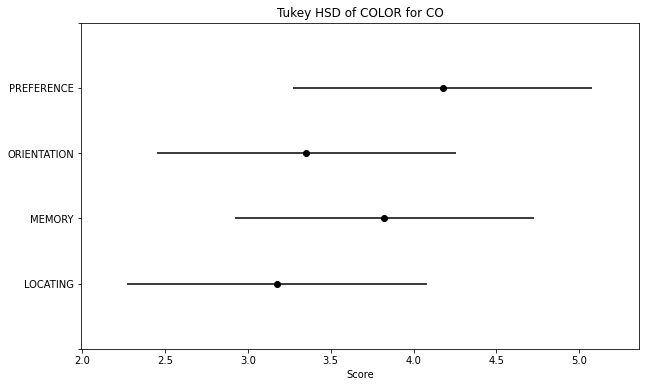

平均分数:
喜好程度: 4.18
辅助记忆区域: 3.82
辅助定位: 3.18
辅助认知朝向: 3.35

用户辅助最大的方面是：喜好程度


In [26]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][3])
    CO_REMEMBER.append(item["post"][6])
    CO_LOCATION.append(item["post"][9])
    CO_ORIENTATION.append(item["post"][12])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][3])
    EX_REMEMBER.append(item["post"][6])
    EX_LOCATION.append(item["post"][9])
    EX_ORIENTATION.append(item["post"][12])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of COLOR for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of COLOR for CO")

### LABELS

正态性检验结果:
喜好程度: 0.042762674391269684
辅助记忆区域: 0.007302337326109409
辅助定位: 0.0069887349382042885
辅助认知朝向: 0.012811788357794285

方差齐性检验结果:
Levene检验p值: 0.7902286830563533

多因素ANOVA结果:
ANOVA p值: 0.7597766895477108

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.2941 0.9495  -1.149 1.7373  False
   LOCATING ORIENTATION  -0.2941 0.9495 -1.7373  1.149  False
   LOCATING  PREFERENCE   0.0588 0.9996 -1.3843  1.502  False
     MEMORY ORIENTATION  -0.5882 0.7058 -2.0314 0.8549  False
     MEMORY  PREFERENCE  -0.2353 0.9731 -1.6784 1.2078  False
ORIENTATION  PREFERENCE   0.3529 0.9169 -1.0902 1.7961  False
-------------------------------------------------------------


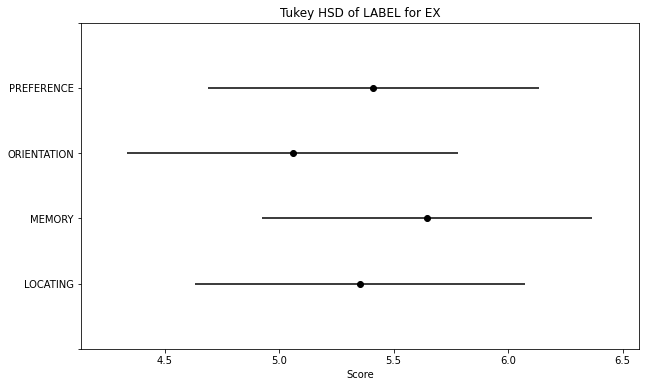

平均分数:
喜好程度: 5.41
辅助记忆区域: 5.65
辅助定位: 5.35
辅助认知朝向: 5.06

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.013239020481705666
辅助记忆区域: 0.21940426528453827
辅助定位: 0.19358886778354645
辅助认知朝向: 0.032714370638132095

方差齐性检验结果:
Levene检验p值: 0.07289710280823304

多因素ANOVA结果:
ANOVA p值: 0.6454739335846076

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.5882 0.7166 -0.8797 2.0562  False
   LOCATING ORIENTATION   0.1176 0.9966 -1.3503 1.5856  False
   LOCATING  PREFERENCE   0.5294 0.7773 -0.9385 1.9974  False
     MEMORY ORIENTATION  -0.4706 0.8324 -1.9385 0.9974  False
     MEMORY  PREFERENCE  -0.0588 0.9996 -1.5268 1.4091  False
ORIENTATION  PREFERENCE   0.4118 0.8806 -1.0562 1.8797  False
-------------------------------------------------------------


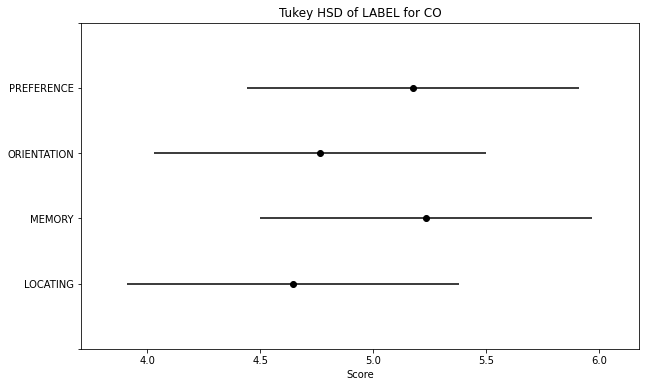

平均分数:
喜好程度: 5.18
辅助记忆区域: 5.24
辅助定位: 4.65
辅助认知朝向: 4.76

用户辅助最大的方面是：辅助记忆区域


In [27]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][4])
    CO_REMEMBER.append(item["post"][7])
    CO_LOCATION.append(item["post"][10])
    CO_ORIENTATION.append(item["post"][13])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][4])
    EX_REMEMBER.append(item["post"][7])
    EX_LOCATION.append(item["post"][10])
    EX_ORIENTATION.append(item["post"][13])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LABEL for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LABEL for CO")

### LANDMARKS

正态性检验结果:
喜好程度: 0.008382744155824184
辅助记忆区域: 0.0005955854430794716
辅助定位: 0.0024297882337123156
辅助认知朝向: 0.004122786223888397

方差齐性检验结果:
Levene检验p值: 0.05558789228254143

多因素ANOVA结果:
ANOVA p值: 0.1564010178270723

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1176 0.9917 -0.9637  1.199  False
   LOCATING ORIENTATION  -0.7059 0.3209 -1.7872 0.3754  False
   LOCATING  PREFERENCE  -0.4706 0.6614 -1.5519 0.6107  False
     MEMORY ORIENTATION  -0.8235 0.1955 -1.9048 0.2578  False
     MEMORY  PREFERENCE  -0.5882 0.4826 -1.6695 0.4931  False
ORIENTATION  PREFERENCE   0.2353 0.9395  -0.846 1.3166  False
-------------------------------------------------------------


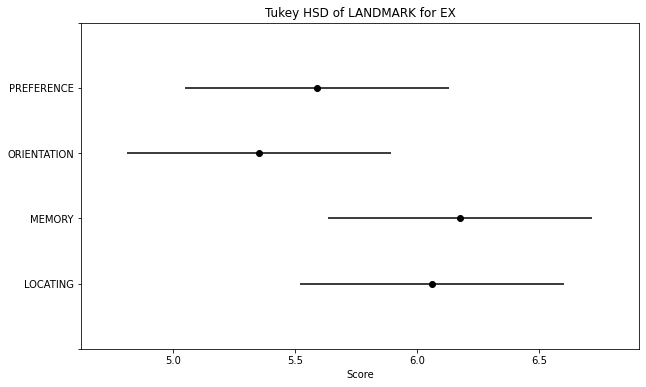

平均分数:
喜好程度: 5.59
辅助记忆区域: 6.18
辅助定位: 6.06
辅助认知朝向: 5.35

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.0155388955026865
辅助记忆区域: 0.005321977660059929
辅助定位: 0.006484044715762138
辅助认知朝向: 0.06818811595439911

方差齐性检验结果:
Levene检验p值: 0.338961604873718

多因素ANOVA结果:
ANOVA p值: 0.5452405739166462

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1765 0.9907 -1.3834 1.7364  False
   LOCATING ORIENTATION  -0.6471 0.6943  -2.207 0.9128  False
   LOCATING  PREFERENCE  -0.1765 0.9907 -1.7364 1.3834  False
     MEMORY ORIENTATION  -0.8235 0.5086 -2.3834 0.7364  False
     MEMORY  PREFERENCE  -0.3529 0.9327 -1.9128  1.207  False
ORIENTATION  PREFERENCE   0.4706 0.8561 -1.0893 2.0305  False
-------------------------------------------------------------


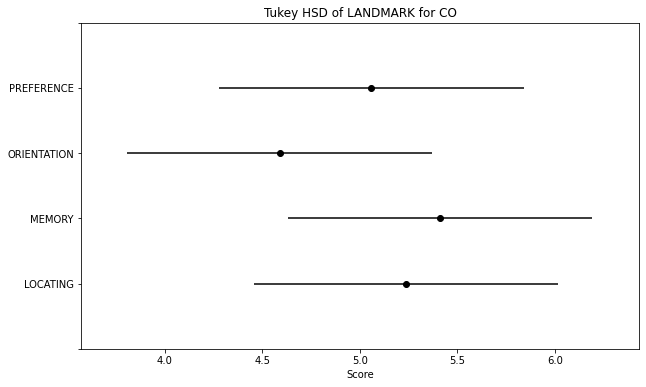

平均分数:
喜好程度: 5.06
辅助记忆区域: 5.41
辅助定位: 5.24
辅助认知朝向: 4.59

用户辅助最大的方面是：辅助记忆区域


In [28]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][5])
    CO_REMEMBER.append(item["post"][8])
    CO_LOCATION.append(item["post"][11])
    CO_ORIENTATION.append(item["post"][14])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][5])
    EX_REMEMBER.append(item["post"][8])
    EX_LOCATION.append(item["post"][11])
    EX_ORIENTATION.append(item["post"][14])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LANDMARK for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LANDMARK for CO")

In [29]:
CO_MAP = []
CO_AR = []
EX_MAP = []
EX_AR = []
for item in co_json_datas:
    CO_MAP.append(item["post"][22])
    CO_AR.append(item["post"][23])
    
for item in ex_json_datas:
    EX_MAP.append(item["post"][22])
    EX_AR.append(item["post"][23])
print(np.mean(CO_MAP), np.mean(CO_AR))
diff_analysis(CO_MAP, CO_AR)
print("\n")
print(np.mean(EX_MAP), np.mean(EX_AR))
diff_analysis(EX_MAP, EX_AR)
print("\n")
diff_analysis(CO_AR, EX_AR)

4.176470588235294 5.588235294117647
Levene's test statistic for variance comparison: 2.9411764705882364
P-value for variance comparison: 0.09601808710650628
The statistical value of t test is STA: -2.626443144789996 and p_value: 0.01312974621290345
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


4.529411764705882 5.588235294117647
Levene's test statistic for variance comparison: 2.7341772151898747
P-value for variance comparison: 0.10800077473676103
The statistical value of t test is STA: -2.1121727358558866 and p_value: 0.04256883037488899
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


Levene's test statistic for variance comparison: 0.0
P-value for variance comparison: 1.0
The statistical value of t test is STA: 0.0 and p_value: 1.0
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


In [30]:
ex_0_score = avg_frame_ex["0_EX"].to_list()
ex_1_score = avg_frame_ex["1_EX"].to_list()
co_0_score = avg_frame_co["0_CO"].to_list()
co_1_score = avg_frame_co["1_CO"].to_list()

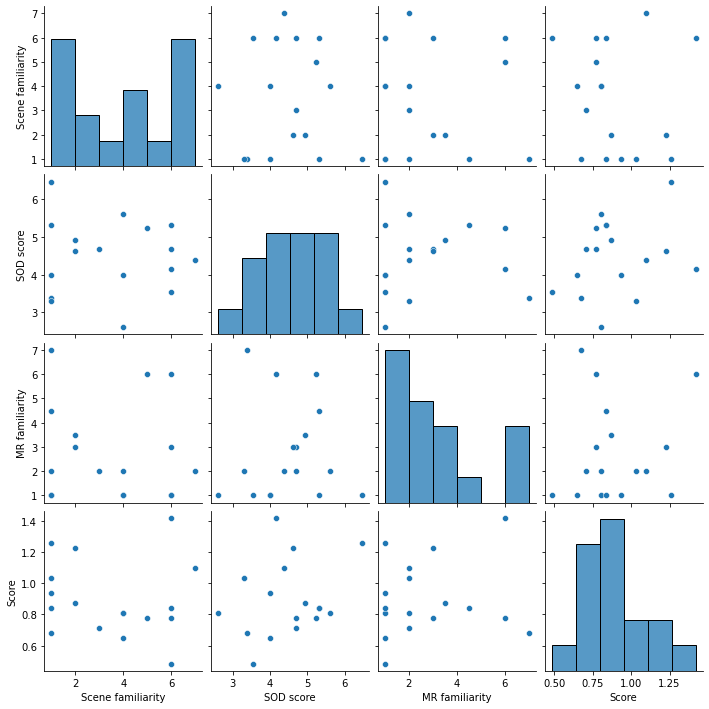

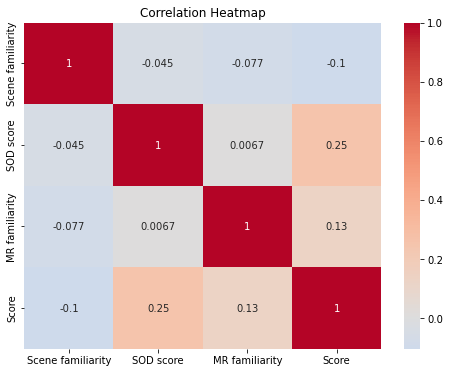

Linear Regression:
Mean Squared Error: 0.17969177545149462
R-squared: -1.3120843007047536

Polynomial Regression:
Mean Squared Error: 0.16664523368669235
R-squared: -1.144215157461574

Ridge Regression:
Mean Squared Error: 0.175052027751045
R-squared: -1.2523849194142822

Lasso Regression:
Mean Squared Error: 0.09556262604139207
R-squared: -0.22959911130748467

Decision Tree Regression:
Mean Squared Error: 0.2921436004162331
R-squared: -2.758995815899581


In [31]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score)

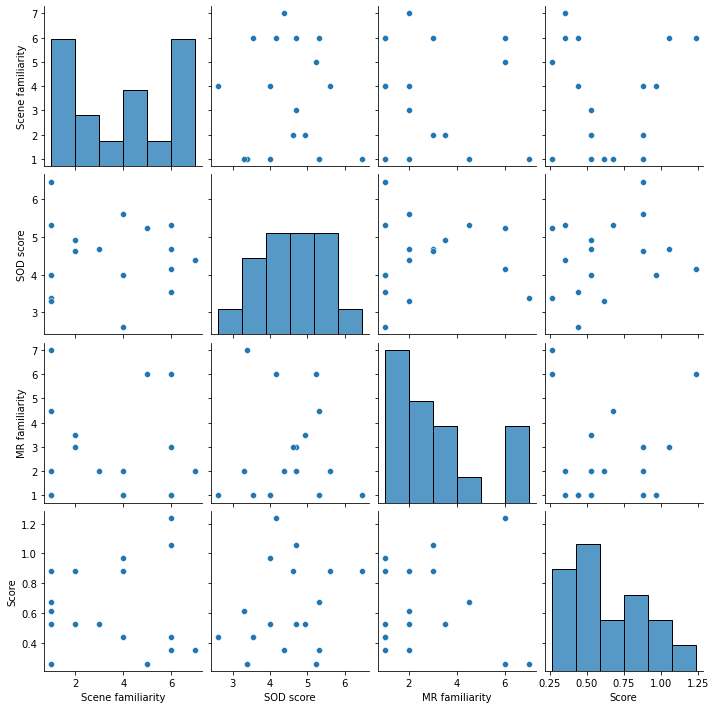

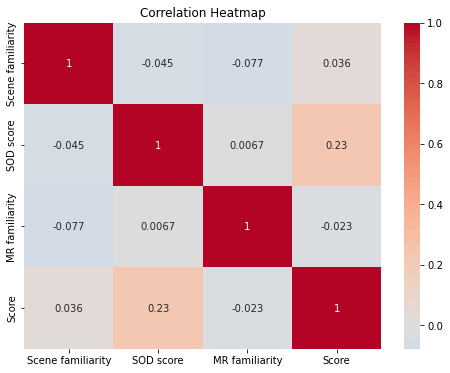

Linear Regression:
Mean Squared Error: 0.22532407553643802
R-squared: -2.2083095466681733

Polynomial Regression:
Mean Squared Error: 0.8094121185145037
R-squared: -10.524931904576025

Ridge Regression:
Mean Squared Error: 0.22274381139466537
R-squared: -2.1715700812592225

Lasso Regression:
Mean Squared Error: 0.15843800200340216
R-squared: -1.255942482721267

Decision Tree Regression:
Mean Squared Error: 0.291522491349481
R-squared: -3.1508852963818317


In [32]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score)

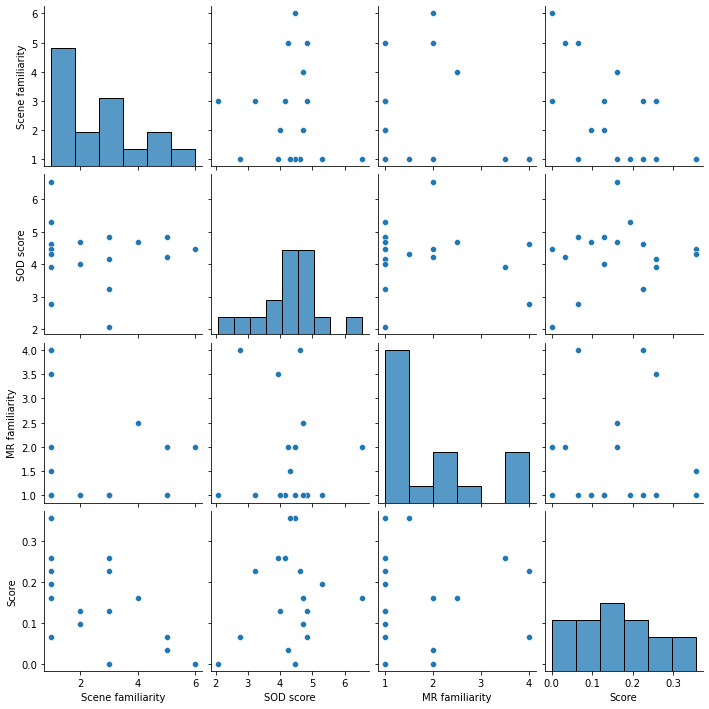

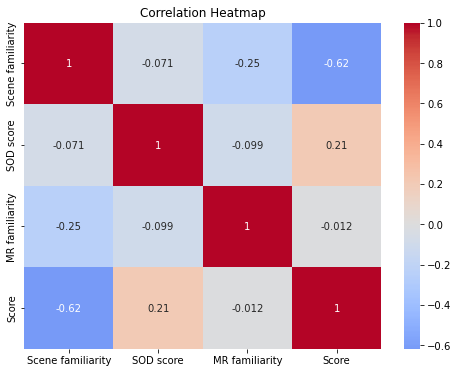

Linear Regression:
Mean Squared Error: 0.012932604381039811
R-squared: -0.1109034914126712

Polynomial Regression:
Mean Squared Error: 0.02185060244532526
R-squared: -0.8769545430129675

Ridge Regression:
Mean Squared Error: 0.01213936155656022
R-squared: -0.04276437594228999

Lasso Regression:
Mean Squared Error: 0.011721389439766784
R-squared: -0.00686080461370997

Decision Tree Regression:
Mean Squared Error: 0.017429760665972942
R-squared: -0.4972067039106143


In [33]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score)

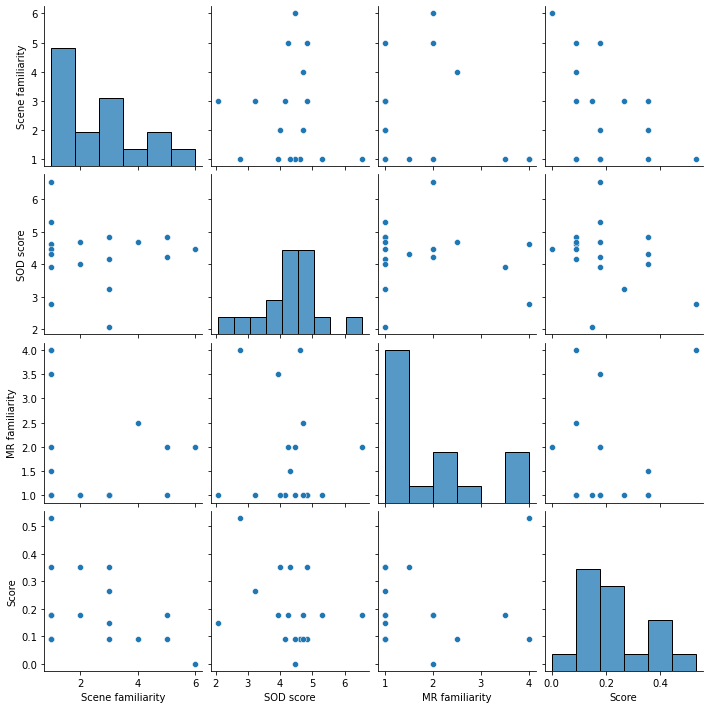

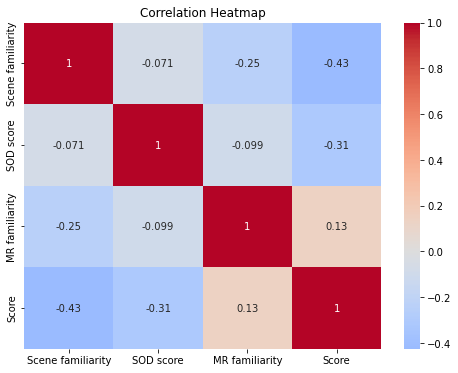

Linear Regression:
Mean Squared Error: 0.025946759944242007
R-squared: -38.99260599405835

Polynomial Regression:
Mean Squared Error: 0.149437673985185
R-squared: -229.33326816916517

Ridge Regression:
Mean Squared Error: 0.02393101059123729
R-squared: -35.88566432462708

Lasso Regression:
Mean Squared Error: 0.015299645789398242
R-squared: -22.581854043392493

Decision Tree Regression:
Mean Squared Error: 0.056012110726643596
R-squared: -85.33333333333333


In [34]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score)

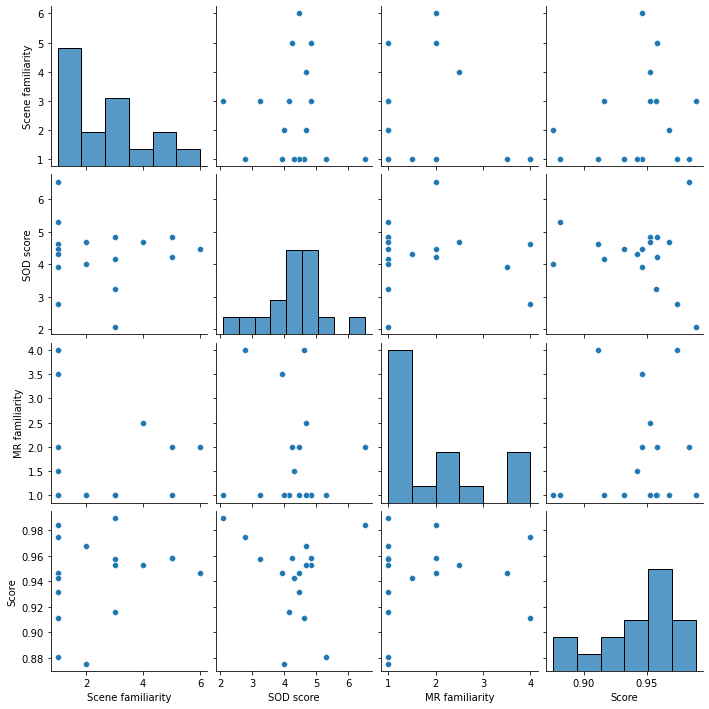

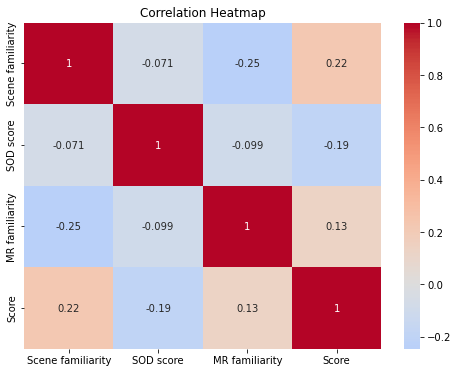

Linear Regression:
Mean Squared Error: 0.0024287917783372154
R-squared: -1.3647307929875017

Polynomial Regression:
Mean Squared Error: 0.0007765724294876043
R-squared: 0.2439101806200663

Ridge Regression:
Mean Squared Error: 0.002199333750886228
R-squared: -1.1413248723766385

Lasso Regression:
Mean Squared Error: 0.0010271032625179602
R-squared: -1.2736421955317212e-05

Decision Tree Regression:
Mean Squared Error: 0.001005574265647529
R-squared: 0.020948418954029324


In [35]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score)

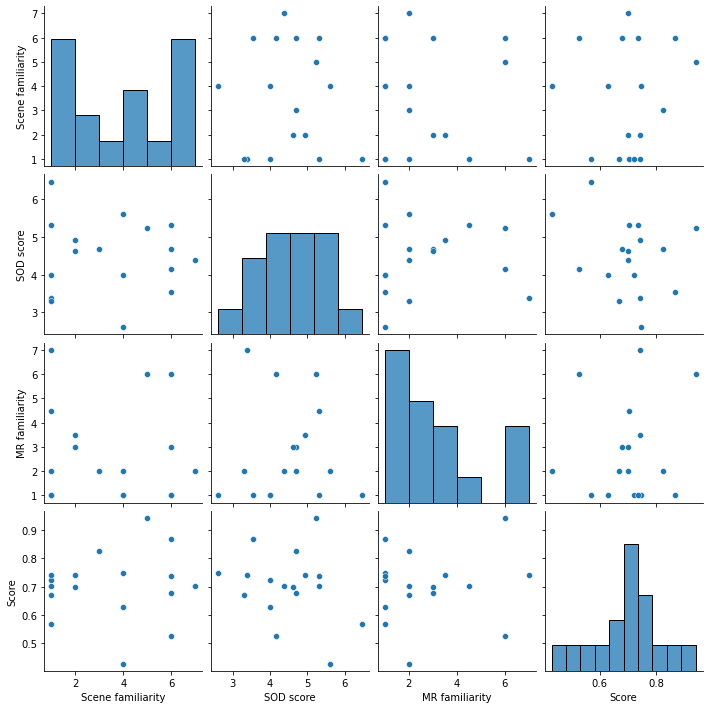

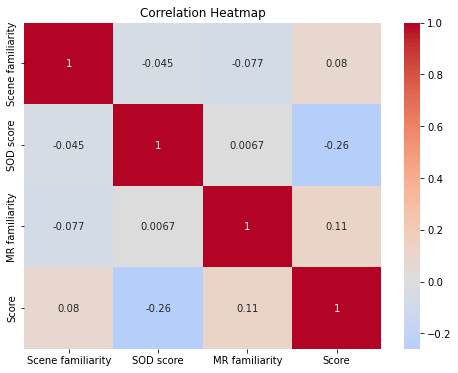

Linear Regression:
Mean Squared Error: 0.05083410022887938
R-squared: -1.1358257607778826

Polynomial Regression:
Mean Squared Error: 0.05966141002806822
R-squared: -1.5067105720086644

Ridge Regression:
Mean Squared Error: 0.05049114447184988
R-squared: -1.1214162652350748

Lasso Regression:
Mean Squared Error: 0.03510081258161745
R-squared: -0.4747820734213404

Decision Tree Regression:
Mean Squared Error: 0.07162483149797952
R-squared: -2.0093610300168407


In [36]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score)

In [37]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score)

Spearman Correlation and p-value for scene familiarity: -0.1581247148626288 0.544422982249895
Spearman Correlation and p-value for sod: 0.20479704797047968 0.4304077010481817
Spearman Correlation and p-value for mr familiarity: 0.07525034979125812 0.7740823894038653


In [38]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score)

Spearman Correlation and p-value for scene familiarity: -0.06179774427936791 0.8137313949737522
Spearman Correlation and p-value for sod: 0.17861775811795658 0.4927685574701649
Spearman Correlation and p-value for mr familiarity: -0.008261373296929612 0.9748961222946784


In [39]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score)

Spearman Correlation and p-value for scene familiarity: 0.06012715305841442 0.818687170970622
Spearman Correlation and p-value for sod: -0.21976710073170855 0.3966958000221451
Spearman Correlation and p-value for mr familiarity: 0.04923300652392964 0.851155954038556


In [40]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score)

Spearman Correlation and p-value for scene familiarity: -0.6003324524208774 0.010834113566506527
Spearman Correlation and p-value for sod: 0.049938499572236554 0.8490458880886456
Spearman Correlation and p-value for mr familiarity: -0.014712260317393295 0.9553081291666594


In [41]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score)

Spearman Correlation and p-value for scene familiarity: -0.3842584285516685 0.12780193005210605
Spearman Correlation and p-value for sod: -0.24235238932400646 0.348650983828532
Spearman Correlation and p-value for mr familiarity: -0.0342288520960714 0.8962367909241207


In [42]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score)

Spearman Correlation and p-value for scene familiarity: 0.22669589867927184 0.38159126526507514
Spearman Correlation and p-value for sod: -0.0927519127431706 0.7232929875854129
Spearman Correlation and p-value for mr familiarity: 0.11593149184902413 0.657702041790301
